File to Open the pickled results from the pnas_longruns.py script and make sure we can do analysis etc. on them.

The initial run had the following parameters:

$s = 100$

$n = 130$

$k \in 15, 20, 25, 30, 35$

$m \in 5, 7, 9, 11, 13, 15$

$l \in 3, 4, 5, 6$

$\phi \in 0.0, 0.1, 0.2, 0.35, 0.5$

As confirmed in the other notebook, there is no change varying phi.  It doesn't seem to make a difference.  We set it to 0.5 so we get a bit of noise but it doesn't really matter unless we are judging against the underlying ordering.  Then we don't get a dropoff till we get very close to 1.0

Everyone does worse as we sweep l.  We maintain an advantage of about 3-5% increase on average, a 10-20% decrease in standerded deviation, and in the worst case, select 0-2 more people in the vanilla set.


In [1]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

_DEBUG = False

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 22}

matplotlib.rc('font', **font)

### Load Datafiles..
## Load some stuff from Pickle..
import pickle

## Open an older file
with open("/Users/Nick/repo/adtvisitors.git-forge/omer/prize/src/peerselect/notebooks/exact_dollar/pickled_runs/s1000PNAS_LongPickle_versus_vanilla.pickle", 'rb') as input_file:
     results = pickle.load(input_file)
        
## Open an older file
with open("/Users/Nick/repo/adtvisitors.git-forge/omer/prize/src/peerselect/notebooks/exact_dollar/pickled_runs/s1000PNAS_LongPickle_versus_base.pickle", 'rb') as input_file:
     base_results = pickle.load(input_file)

# Print the keys.
print("n, k, m, l, p, s")
for k,v in results.items():
    print(k)

n, k, m, l, p, s
(130, 15, 11, 5, 0.5, 1000, 'DollarPartitionRaffle')
(130, 35, 7, 5, 0.5, 1000, 'DollarRaffle')
(130, 25, 7, 5, 0.5, 1000, 'ExactDollarPartition')
(130, 15, 7, 5, 0.5, 1000, 'Vanilla')
(130, 20, 15, 3, 0.5, 1000, 'DollarRaffle')
(130, 20, 15, 5, 0.5, 1000, 'ExactDollarPartition')
(130, 25, 11, 5, 0.5, 1000, 'DollarRaffle')
(130, 15, 7, 4, 0.5, 1000, 'CredibleSubset')
(130, 30, 7, 6, 0.5, 1000, 'Partition')
(130, 15, 9, 4, 0.5, 1000, 'DollarPartitionRaffle')
(130, 25, 9, 3, 0.5, 1000, 'Partition')
(130, 35, 7, 5, 0.5, 1000, 'ExactDollarPartition')
(130, 35, 11, 5, 0.5, 1000, 'DollarRaffle')
(130, 25, 5, 5, 0.5, 1000, 'DollarPartitionRaffle')
(130, 20, 13, 6, 0.5, 1000, 'ExactDollarPartition')
(130, 25, 5, 3, 0.5, 1000, 'CredibleSubset')
(130, 20, 5, 5, 0.5, 1000, 'DollarPartitionRaffle')
(130, 25, 13, 6, 0.5, 1000, 'CredibleSubset')
(130, 25, 15, 3, 0.5, 1000, 'Vanilla')
(130, 35, 7, 4, 0.5, 1000, 'DollarPartitionRaffle')
(130, 20, 13, 4, 0.5, 1000, 'Vanilla')
(130, 15,

In [26]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    print(means)
    print(errors)

    print("\t\tApproximate Vanilla Ordering")
    means = means[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    errors = errors[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
    errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
    mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
    print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    del means['PercentChange']
    del errors['PercentChange']
    del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.ix[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.ix[index] = row / float(index[1])
    
    print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 6))
    color_list = color_list[:6]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(20, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75)
    plt.title("Strict Preference, Borda Scoring, Versus Vanilla Ordering")
    plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=6, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
    plt.gca().set_xlabel("")
    plt.show()
    
v_df = pd.DataFrame(results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df = pd.DataFrame(base_results)
gt_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']



		Approximate Vanilla Ordering
		 MEAN:
algo                  Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                            
130 30 5  4 0.5 1000   24.566                23.765     23.566       0.844437
       7  4 0.5 1000   25.479                24.602     24.395       0.848535
       9  4 0.5 1000   25.837                24.886     24.552       1.360378
       11 4 0.5 1000   26.529                25.571     25.217       1.403815
       13 4 0.5 1000   26.888                25.855     25.497       1.404087
       15 4 0.5 1000   27.172                26.129     25.731       1.546772
		 STD:
algo                   Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                             
130 30 5  4 0.5 1000  1.499965              1.489293   1.536230      -3.055379
       7  4 0.5 1000  1.332417              1.416899   1.466672      -3.393567
       9  4 

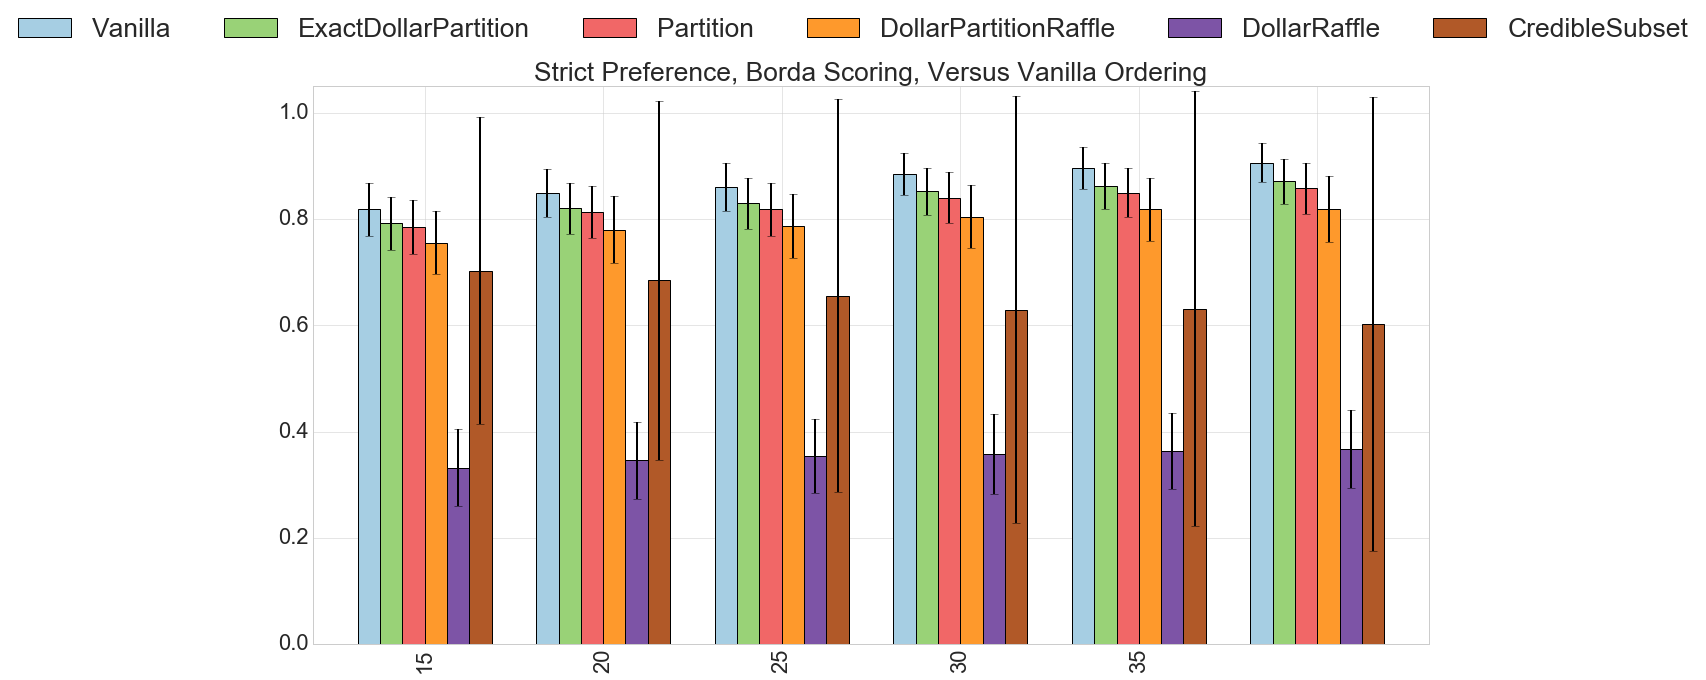

In [27]:
#  Vary the number of Selected
#  ['n', 'k', 'm', 'l', 'p', 's', 'algo']
# make_output(v_df, (130, 30, slice(None), 4, 0.5, 1000), v_df.columns.levels[2])
# make_output(v_df, (130, 30, slice(None), 4, 0.5, 1000), v_df.columns.levels[2])

make_output(gt_df, (130, 30, slice(None), 4, 0.5, 1000), v_df.columns.levels[1])

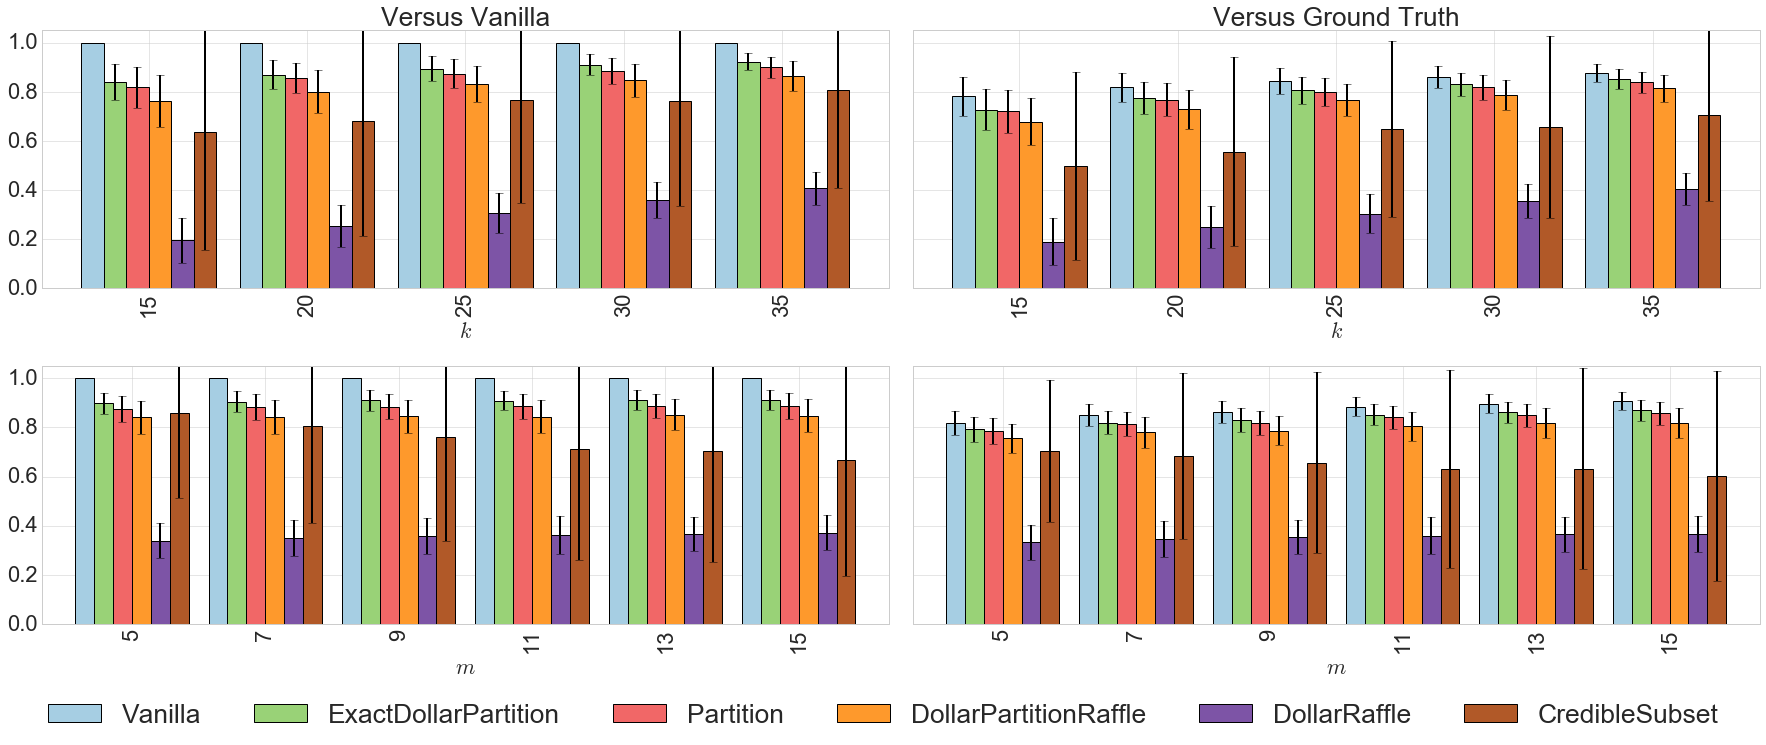

In [39]:
### Publication Graphic... 2x2
#
#  k=25: v_df v. m, b_df v. m
#  k=35: v_df v. m, b_df v. m

t = (130, slice(None), 9, 4, 0.5, 1000)
t2 = (130, 30, slice(None), 4, 0.5, 1000)

v_1m = v_df.loc[:, t].mean().unstack()
gt_1m = gt_df.loc[:, t].mean().unstack()
v_1e = v_df.loc[:, t].std().unstack()
gt_1e = gt_df.loc[:, t].std().unstack()

v_2m = v_df.loc[:, t2].mean().unstack()
gt_2m = gt_df.loc[:, t2].mean().unstack()
v_2e = v_df.loc[:, t2].std().unstack()
gt_2e = gt_df.loc[:, t2].std().unstack()

v_1m = v_1m[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
gt_1m = gt_1m[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
v_1e = v_1e[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
gt_1e = gt_1e[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]

v_2m = v_2m[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
gt_2m = gt_2m[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
v_2e = v_2e[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
gt_2e = gt_2e[['Vanilla','ExactDollarPartition', 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]

#Normalize
for index, row in v_1m.iterrows():
    v_1m.ix[index] = v_1m.ix[index] / float(index[1])
    v_1e.ix[index] = v_1e.ix[index] / float(index[1])
    gt_1m.ix[index] = gt_1m.ix[index] / float(index[1])
    gt_1e.ix[index] = gt_1e.ix[index] / float(index[1])

for index, row in v_2m.iterrows():
    v_2m.ix[index] = v_2m.ix[index] / float(index[1])
    v_2e.ix[index] = v_2e.ix[index] / float(index[1])
    gt_2m.ix[index] = gt_2m.ix[index] / float(index[1])
    gt_2e.ix[index] = gt_2e.ix[index] / float(index[1])
    
fig, axarr = plt.subplots(nrows=2, ncols=2, sharey=True)
fig.set_size_inches(25,10)
 
#Set colors..
color_list = plt.cm.Paired(np.linspace(0, 1, 6))
color_list = color_list[:6]

v_1m.plot(ax=axarr[0,0], kind='bar', legend=False, yerr=v_1e.values.T, ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.85)

v_2m.plot(ax=axarr[1,0], kind='bar', legend=False, yerr=v_2e.values.T, ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.85)


gt_1m.plot(ax=axarr[0,1], kind='bar', legend=False, yerr=gt_1e.values.T, ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.85)

gt_2m.plot(ax=axarr[1,1], kind='bar', legend=False, yerr=gt_2e.values.T, ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.85)

#plt.title("Strict Preference, Borda Scoring, Versus Vanilla Ordering")
plt.legend(bbox_to_anchor = (0,-0.05,1,1), bbox_transform=plt.gcf().transFigure, loc='lower center', ncol=6, borderaxespad=0.)
axarr[0,0].set_title("Versus Vanilla")
axarr[0,0].set_xticklabels(v_df.columns.levels[1])
axarr[0,0].set_xlabel("$k$")

axarr[1, 0].set_xticklabels(v_df.columns.levels[2])
axarr[1, 0].set_xlabel("$m$")

axarr[0,1].set_title("Versus Ground Truth")
axarr[0,1].set_xticklabels(v_df.columns.levels[1])
axarr[0,1].set_xlabel("$k$")

axarr[1, 1].set_xticklabels(v_df.columns.levels[2])
axarr[1, 1].set_xlabel("$m$")

plt.tight_layout()
plt.savefig("test.pdf",bbox_inches='tight')
plt.show()